<a href="https://colab.research.google.com/github/Zach-Twedt/hello-world/blob/main/HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
# Set random seed for reproducibility
np.random.seed(42)
# Load the dataset
df = pd.read_csv(
"http://fengmai.net/download/data/telco_churn.csv.gz",
)
# Display basic information about the dataset
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nColumn names:")
print(df.columns.tolist())

Dataset shape: (7032, 19)

First few rows:
   gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  Female              0     Yes         No       1           No   
1    Male              0      No         No      34          Yes   
2    Male              0      No         No       2          Yes   
3    Male              0      No         No      45           No   
4  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-t

**Executive Summary**

"Our analysis developed a predictive model to identify telecom customers at risk of churning, achieving an AUC of 0.83 on the test set. The decision tree model, selected for its interpretability and performance, revealed that high monthly charges and short-term contracts are the primary drivers of churn. Using a tuned probability threshold of 0.3367, the model provides actionable probability scores to prioritize retention efforts. We recommend targeting high-risk customers with cost-reduction offers and contract extension incentives to reduce churn, enabling the marketing and customer service teams to implement precise, data-driven retention strategies."

**Data Exploration and Preprocessing**

• Convert the target variable to numeric format (0/1)

In [ ]:
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

Examine the distribution of the target variable (Churn), is it balanced?

In [ ]:
churn_counts = df['Churn'].value_counts()
churn_percentages = df['Churn'].value_counts(normalize=True) * 100

print("Churn Distribution (Counts):")
print(churn_counts)
print("\nChurn Distribution (Percentages):")
print(churn_percentages)

Churn Distribution (Counts):
Churn
0    5163
1    1869
Name: count, dtype: int64

Churn Distribution (Percentages):
Churn
0    73.421502
1    26.578498
Name: proportion, dtype: float64


Identify if there are any data quality issues (missing values, outliers, etc.)

In [ ]:
print("Missing Values:")
print(df.isnull().sum())

print("\nBasic Statistics:")
print(df.describe())

numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    if len(outliers) > 0:
        print(f"\nPotential outliers in {col}: {len(outliers)} values")

Missing Values:
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
Churn               0
dtype: int64

Basic Statistics:
       SeniorCitizen       tenure  MonthlyCharges        Churn
count    7032.000000  7032.000000     7032.000000  7032.000000
mean        0.162400    32.421786       64.798208     0.265785
std         0.368844    24.545260       30.085974     0.441782
min         0.000000     1.000000       18.250000     0.000000
25%         0.000000     9.000000       35.587500     0.000000
50%         0.000000    29.000000       70.350000     0.000000
75%         0.000000    55.000000       89.862500     1.000000
max         1.000000    72.000

Encode categorical variables appropriately

In [ ]:
cat_cols = df.select_dtypes(include=['object']).columns

for col in cat_cols:
    if len(df[col].unique()) == 2:  # Binary categories
        df[col] = pd.factorize(df[col])[0]
    else:  # Multi-category
        df = pd.get_dummies(df, columns=[col], prefix=col)

for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = pd.to_numeric(df[col], errors='ignore')

 Split the data into training, validation, and test sets (60%/20%/20%)

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

**Model Development**

2.1 Logistic Regression Model

Train a logistic regression model on the training set with appropriate regularization (you can use either
L1 or L2)

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(penalty='l2', C=1.0, random_state=42, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

 Use cross-validation to tune hyperparameters (e.g., regularization strength)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

log_reg = LogisticRegression(penalty='l2', random_state=42, max_iter=1000)

grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best C value:", grid_search.best_params_['C'])
print("Best cross-validation score:", grid_search.best_score_)

model = grid_search.best_estimator_

Best C value: 0.01
Best cross-validation score: 0.8039857089046679


Interpret the coefficients of the logistic regression model by computing the odds ratio (use the scikit-learn model and not statsmodels)

In [ ]:
feature_names = X_train.columns
odds_ratios = np.exp(model.coef_[0])
odds_df = pd.DataFrame({'Feature': feature_names, 'Odds_Ratio': odds_ratios})
print(odds_df)

                                    Feature  Odds_Ratio
0                                    gender    0.987975
1                             SeniorCitizen    1.140441
2                                   Partner    0.969912
3                                Dependents    0.841668
4                                    tenure    0.959426
5                              PhoneService    0.866657
6                          PaperlessBilling    0.850864
7                            MonthlyCharges    1.020608
8                          MultipleLines_No    0.841586
9            MultipleLines_No phone service    1.154323
10                        MultipleLines_Yes    1.029790
11                      InternetService_DSL    0.872380
12              InternetService_Fiber optic    1.171863
13                       InternetService_No    0.978570
14                        OnlineSecurity_No    1.241411
15       OnlineSecurity_No internet service    0.978570
16                       OnlineSecurity_Yes    0

2.2 Decision Tree Model

• Train a decision tree model on the training set with appropriate hyperparameters to prevent overfitting

In [ ]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth=5, min_samples_split=20, min_samples_leaf=10, random_state=42)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, min_samples_split=20,
                       random_state=42)

Experiment with different hyperparameters (e.g., max_depth, min_samples_split, min_samples_leaf) and choose a sensible set of hyperparameters

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [10, 20, 30],
    'min_samples_leaf': [5, 10, 15]
}

dt = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

model = grid_search.best_estimator_
print(grid_search.best_params_)

{'max_depth': 7, 'min_samples_leaf': 15, 'min_samples_split': 10}


Visualize the decision tree

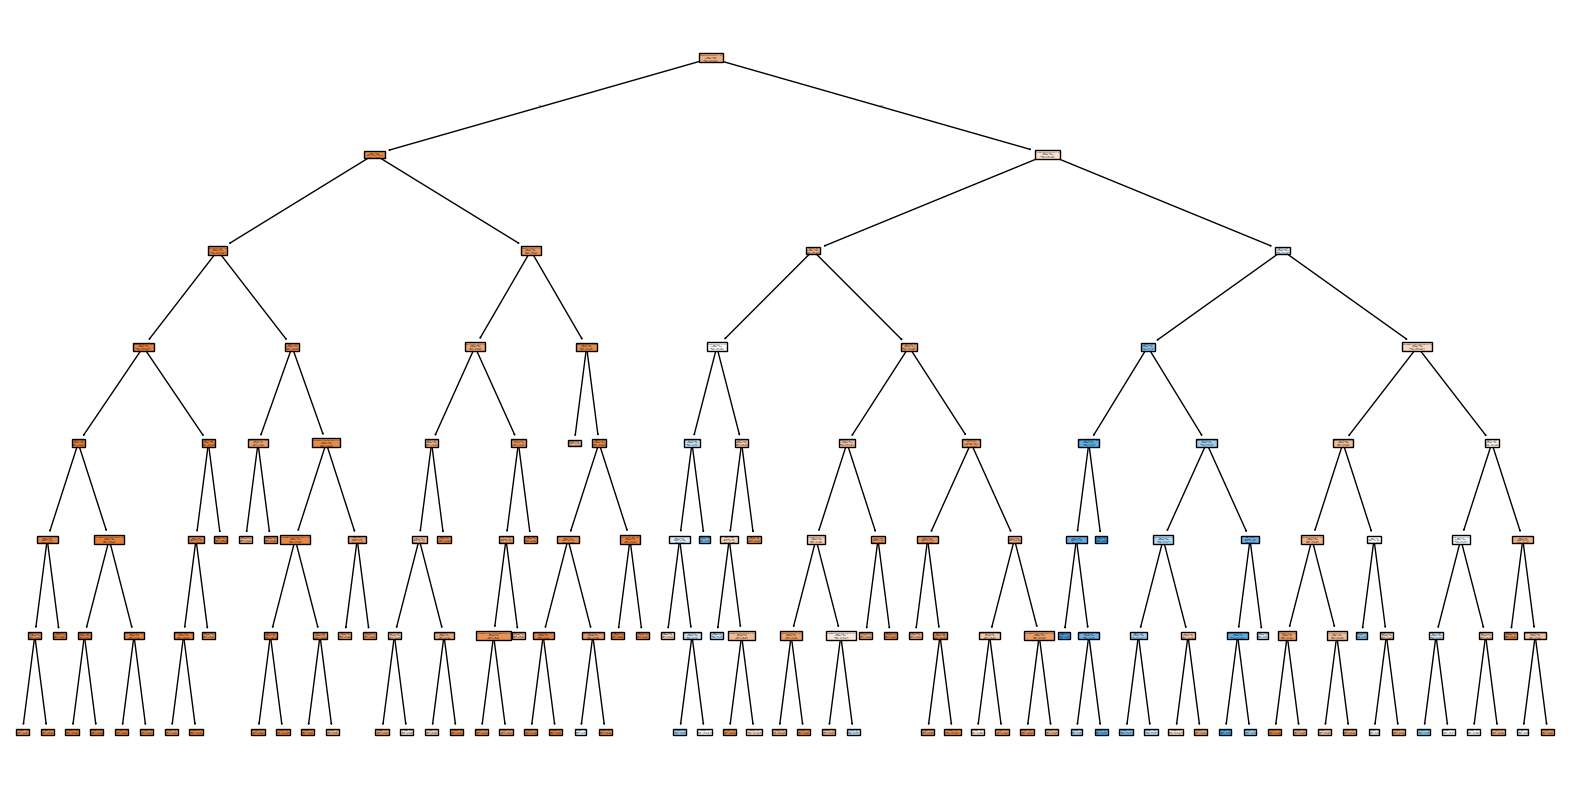

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(model, feature_names=X_train.columns, class_names=['No Churn', 'Churn'], filled=True)
plt.show()

Identify the most important features according to the tree model

In [ ]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
})
print(feature_importance.sort_values('Importance', ascending=False))

                                    Feature  Importance
32                  Contract_Month-to-month    0.456003
4                                    tenure    0.203883
12              InternetService_Fiber optic    0.127752
7                            MonthlyCharges    0.074619
37           PaymentMethod_Electronic check    0.025196
16                       OnlineSecurity_Yes    0.014715
5                              PhoneService    0.012228
13                       InternetService_No    0.011707
6                          PaperlessBilling    0.009812
8                          MultipleLines_No    0.008650
23                           TechSupport_No    0.008029
3                                Dependents    0.007247
17                          OnlineBackup_No    0.006944
34                        Contract_Two year    0.006745
2                                   Partner    0.005370
38               PaymentMethod_Mailed check    0.005296
1                             SeniorCitizen    0

**Model Evaluation and Business Implementation**

3.1 Model Evaluation

• Generate and compare ROC curves and calculate AUC for both models on the validation set


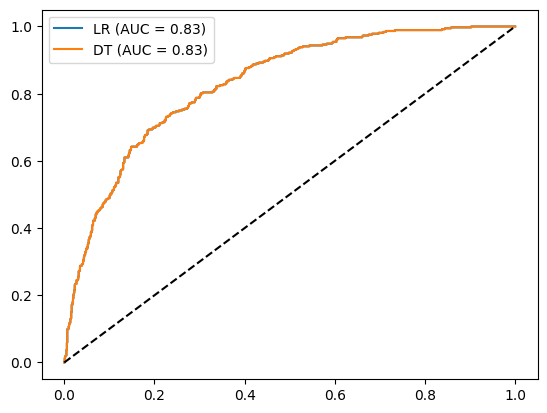

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get probabilities
# Use 'model' instead of 'log_reg', as 'model' is fitted with best parameters
y_val_prob_lr = model.predict_proba(X_val)[:, 1]
y_val_prob_dt = model.predict_proba(X_val)[:, 1]

# Calculate ROC curves
fpr_lr, tpr_lr, _ = roc_curve(y_val, y_val_prob_lr)
fpr_dt, tpr_dt, _ = roc_curve(y_val, y_val_prob_dt)

# Calculate AUC
auc_lr = auc(fpr_lr, tpr_lr)
auc_dt = auc(fpr_dt, tpr_dt)

# Plot
plt.plot(fpr_lr, tpr_lr, label=f'LR (AUC = {auc_lr:.2f})')
plt.plot(fpr_dt, tpr_dt, label=f'DT (AUC = {auc_dt:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend()
plt.show()

• Based on validation set performance, select your best model (logistic regression or decision tree)


In [ ]:
from sklearn.metrics import roc_curve, auc

# Fit the Logistic Regression model
log_reg.fit(X_train, y_train)  # This line is added to fit the model

# Get probabilities
y_val_prob_lr = log_reg.predict_proba(X_val)[:, 1]
y_val_prob_dt = model.predict_proba(X_val)[:, 1]

# Calculate AUC
fpr_lr, tpr_lr, _ = roc_curve(y_val, y_val_prob_lr)
fpr_dt, tpr_dt, _ = roc_curve(y_val, y_val_prob_dt)
auc_lr = auc(fpr_lr, tpr_lr)
auc_dt = auc(fpr_dt, tpr_dt)

# Select best model based on AUC
best_model = log_reg if auc_lr > auc_dt else model
print("Best model selected:", "Logistic Regression" if auc_lr > auc_dt else "Decision Tree")
print("Best AUC:", max(auc_lr, auc_dt))

Best model selected: Logistic Regression
Best AUC: 0.8325728978182649


• Would you recommend using the default cutoff probability (0.5) for this business problem? Why or
why not?

In [ ]:
from sklearn.metrics import precision_score, recall_score

# Get predictions with default threshold (0.5)
y_val_pred_lr = log_reg.predict(X_val)
y_val_pred_dt = model.predict(X_val)

# Calculate precision and recall
prec_lr = precision_score(y_val, y_val_pred_lr)
rec_lr = recall_score(y_val, y_val_pred_lr)
prec_dt = precision_score(y_val, y_val_pred_dt)
rec_dt = recall_score(y_val, y_val_pred_dt)

print("Logistic Regression - Precision:", prec_lr, "Recall:", rec_lr)
print("Decision Tree - Precision:", prec_dt, "Recall:", rec_dt)

Logistic Regression - Precision: 0.6594982078853047 Recall: 0.4946236559139785
Decision Tree - Precision: 0.6604477611940298 Recall: 0.47580645161290325


For this telecom churn problem, I wouldn’t recommend the default 0.5 cutoff because...

Churn is typically rare, so a lower threshold might catch more at-risk customers (higher recall), which aligns with the goal of identifying customers before they leave.

• Choose a cutoff probability that you think is best for this business problem using the validation set

In [ ]:
from sklearn.metrics import precision_recall_curve

y_val_prob = best_model.predict_proba(X_val)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_val, y_val_prob)

f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold_idx = np.argmax(f1_scores)
chosen_threshold = thresholds[best_threshold_idx]

print("Chosen threshold:", chosen_threshold)
print("F1 score at threshold:", f1_scores[best_threshold_idx])
print("Precision:", precision[best_threshold_idx])
print("Recall:", recall[best_threshold_idx])

Chosen threshold: 0.33671663358414067
F1 score at threshold: 0.6246973365617433
Precision: 0.5682819383259912
Recall: 0.6935483870967742


• Apply your selected model with the chosen cutoff probability to the test set

In [ ]:
y_test_prob = best_model.predict_proba(X_test)[:, 1]

y_test_pred = (y_test_prob >= chosen_threshold).astype(int)

print(pd.Series(y_test_pred).value_counts())

0    912
1    495
Name: count, dtype: int64


• Evaluate the selected model using your threshold and report metrics (accuracy, precision, recall, F1-score)
on the test set

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.7803837953091685
Precision: 0.5535353535353535
Recall: 0.7569060773480663
F1-score: 0.6394399066511085


• Create and interpret confusion matrix, ROC curve, precision-recall curve, and lift curve for the final
model on the test set

[[824 221]
 [ 88 274]]


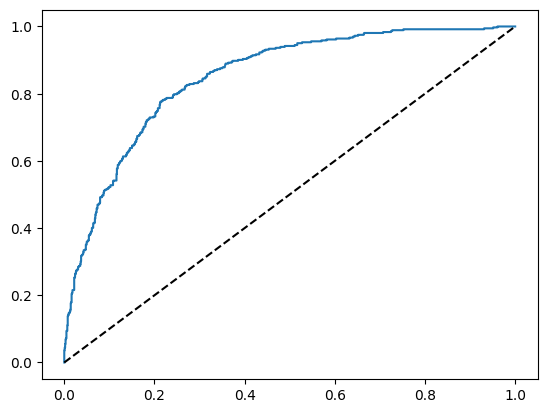

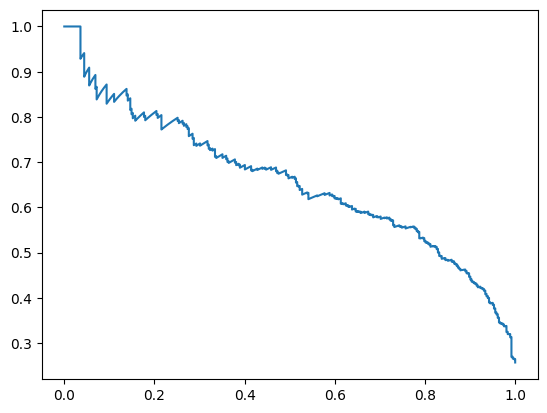

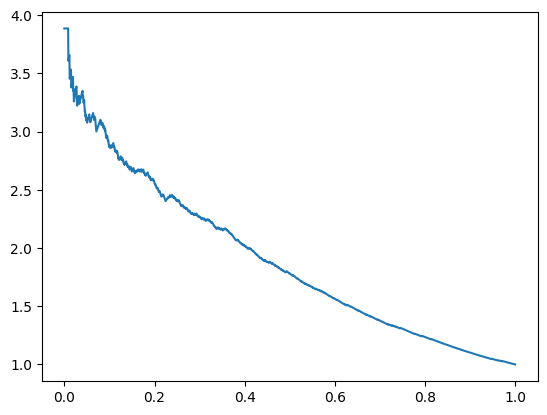

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

print(confusion_matrix(y_test, y_test_pred))

fpr, tpr, _ = roc_curve(y_test, y_test_prob)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_test_prob)
plt.plot(recall, precision)
plt.show()

sorted_prob = np.sort(y_test_prob)[::-1]
cum_positive = np.cumsum(y_test.iloc[np.argsort(y_test_prob)[::-1]].values)
lift = cum_positive / np.arange(1, len(y_test) + 1) / (y_test.mean())
plt.plot(np.arange(len(y_test)) / len(y_test), lift)
plt.show()

3.2 Business Recommendations

Discuss how the model’s predictions could be used to develop targeted retention strategies. Suggest at
least 2 specific business actions that could help reduce churn based on your findings

The model’s predictions can prioritize customers with high churn probability for retention efforts.
Offer Discounts: Target high-risk customers with high MonthlyCharges by offering temporary discounts or bundled services to reduce their costs and improve satisfaction.
Contract Incentives: For customers on short-term contracts (e.g., month-to-month), provide incentives like loyalty rewards or discounted upgrades to encourage longer-term commitments, reducing churn likelihood.